In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

### Load Data

In [2]:
df=pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ST0151EN-SkillsNetwork/labs/boston_housing.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  506 non-null    int64  
 1   CRIM        506 non-null    float64
 2   ZN          506 non-null    float64
 3   INDUS       506 non-null    float64
 4   CHAS        506 non-null    float64
 5   NOX         506 non-null    float64
 6   RM          506 non-null    float64
 7   AGE         506 non-null    float64
 8   DIS         506 non-null    float64
 9   RAD         506 non-null    float64
 10  TAX         506 non-null    float64
 11  PTRATIO     506 non-null    float64
 12  LSTAT       506 non-null    float64
 13  MEDV        506 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 55.5 KB


### Visualisations


**Bar plot of Charles River variable**

- Higher house prices when bounded by charles river


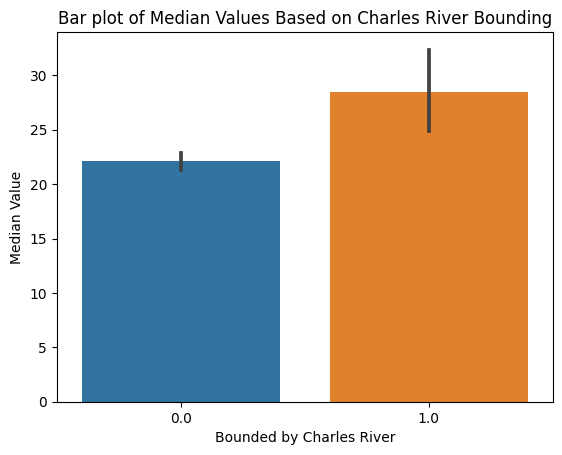

In [28]:
#Bar plot
sns.barplot(x="CHAS", y="MEDV", data = df)
plt.title('Bar plot of Median Values Based on Charles River Bounding')
plt.xlabel('Bounded by Charles River')
plt.ylabel('Median Value')
plt.show()

**Box plot of owner-occupied homes**

- Median value on the whole higher for younger age groups
- Plenty of outliers in the older age group


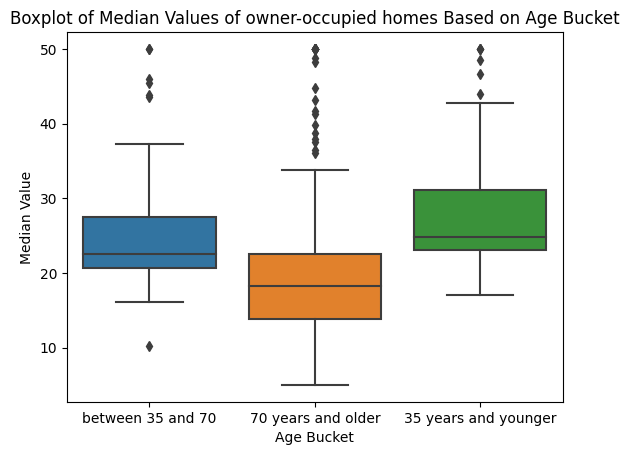

In [29]:
#categorise into buckets
conditions = [
    df["AGE"] <= 35,
    (df["AGE"] > 35) & (df["AGE"] < 70),
    df["AGE"] >= 70,
]
values = ["35 years and younger", "between 35 and 70", "70 years and older"]
df.loc[:, "AGE_BUCKET"] = np.select(conditions, values)

#box plot
# Boxplot
sns.boxplot(x='AGE_BUCKET', y='MEDV', data=df)
plt.title('Boxplot of Median Values of owner-occupied homes Based on Age Bucket')
plt.xlabel('Age Bucket')
plt.ylabel('Median Value')
plt.show()

**Scatter plot of nitric oxide concentrations**
- evidence of positive correlation between two variables.

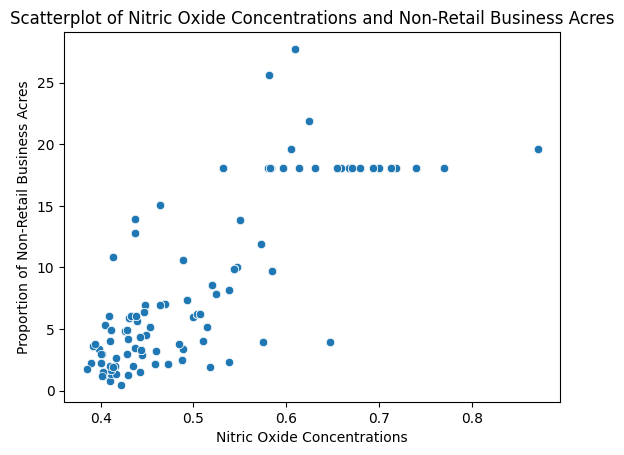

In [30]:
# Scatterplot
sns.scatterplot(x='NOX', y='INDUS', data=df)
plt.title('Scatterplot of Nitric Oxide Concentrations and Non-Retail Business Acres')
plt.xlabel('Nitric Oxide Concentrations')
plt.ylabel('Proportion of Non-Retail Business Acres')
plt.show()

**Histogram of pupil to teacher ratio**
- Distribution non-normal, skewed to the right
- high concentration around 20.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


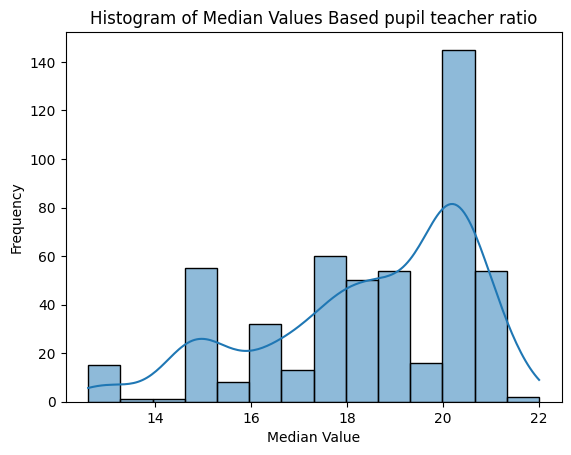

In [31]:
# Histogram
sns.histplot(data=df, x='PTRATIO',kde=True)
plt.title('Histogram of Median Values Based pupil teacher ratio')
plt.xlabel('Median Value')
plt.ylabel('Frequency')
plt.show()

### Statistical Tests

**Is there a significant difference in median value of houses bounded by the Charles river or not?**
 - Use student t-test to compare the median values of houses bounded by the Charles River

In [32]:
# Subset the data for houses bounded and not bounded by the Charles River
bounded = df[df['CHAS'] == 1]['MEDV']
not_bounded = df[df['CHAS'] == 0]['MEDV']

# Perform t-test
t_stat, p_value = stats.ttest_ind(bounded, not_bounded)

# Print results
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Check significance level
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference in median values bounded by the Charles River.")
else:
    print("There is no significant difference in median values bounded by the Charles River.")

T-statistic: 3.996437466090509
P-value: 7.390623170519905e-05
There is a significant difference in median values bounded by the Charles River.


**Is there significant difference in the median values of house of each proportion of owner occupied units built before 1940**

We can use analysis of variance (ANOVA) since we are comparing more than two groups.

In [33]:
# Unique values of proportion of owner-occupied units built before 1940
unique_proportions = df['AGE_BUCKET'].unique()

# List to store the median values for each group
median_values = []

# Loop through each unique proportion value
for proportion in unique_proportions:
    # Subset the data for houses with the current proportion
    subset = df[df['AGE_BUCKET'] == proportion]['MEDV']
    # Calculate the median value for the subset
    median = np.median(subset)
    # Append the median value to the list
    median_values.append(median)

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(*[df[df['AGE_BUCKET'] == proportion]['MEDV'] for proportion in unique_proportions])

# Print results
print("F-statistic:", f_stat)
print("P-value:", p_value)

# Check significance level
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference in median values based on proportions of owner-occupied units built before 1940.")
else:
    print("There is no significant difference in median values based on proportions of owner-occupied units built before 1940.")

F-statistic: 36.40764999196599
P-value: 1.7105011022702984e-15
There is a significant difference in median values based on proportions of owner-occupied units built before 1940.


**Can we conclude there is no relationship between nitric oxide concentrations and proportion of non retail business acres per town**

We can use Pearson's correlation coefficient, which measures the strength and direction of a linear relationship between two continuous variables.

In [34]:
corr, p_value = stats.pearsonr(df['NOX'], df['INDUS'])

# Print results
print("Pearson correlation coefficient:", corr)
print("P-value:", p_value)

# Check significance level
alpha = 0.05
if p_value < alpha:
    print("There is a significant relationship between nitric oxide concentrations and proportion of non-retail business acres per town.")
else:
    print("There is no significant relationship between nitric oxide concentrations and proportion of non-retail business acres per town.")

Pearson correlation coefficient: 0.7636514469209151
P-value: 7.913361061239527e-98
There is a significant relationship between nitric oxide concentrations and proportion of non-retail business acres per town.


**What is the impact of an additional weighted distance to the five Boston’s employment centres of the median value of owner occupied homes**

We can use linear regression

In [35]:
# Prepare the data
X = df['DIS']  # Weighted distances to employment centers
y = df['MEDV']  # Median value of owner-occupied homes

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     33.58
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           1.21e-08
Time:                        15:28:50   Log-Likelihood:                -1823.9
No. Observations:                 506   AIC:                             3652.
Df Residuals:                     504   BIC:                             3660.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.3901      0.817     22.499      0.0

In [36]:
# Extract the coefficient for the 'DIS' variable
impact = model.params['DIS']

# Print the impact
print("Impact of an additional weighted distance to employment centers:", impact)

Impact of an additional weighted distance to employment centers: 1.0916130158411075
